<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymCLIFFDoubleQLearningTODO.ipynb" target="_parent">Ouvrir sur collab</a>


# Machine Learning

## Appliqué à [Gym.OpenAI](https://gym.openai.com)


---

## Test de ML par Double Q-Learning pour atteindre l'objectif

**Utilisation de l'environnement gymnasium**
(voir la page d'introduction à [gymnasium](https://www.gymlibrary.dev/)).


#### Si besoin, installer gym


In [6]:
#!pip install gymnasium 

---

#### L'environnement FrozenLake


In [7]:
import gymnasium as gym

---

- Utiliser l'environnement `CliffWalking` (une grille où il faut trouver le plus court chemin vers l'arrivée)
- Chaque action coûte 1 point, l'arrivée n'en rapporte pas.
- On peut,
  - pour accélérer la résolution en décidant de récompenser l'agent de quelques points s'il parvient au but.
  - ou, _de préférence_, changer la fonction qlearn pour qu'elle retourne
    - total_r : récompense totale;
    - r : récompense du dernier état rencontre
    - states_list : liste des états traverses
    - actions_list : liste des actions effectuées
    - goal : but atteint


---

#### Etude de l'environnement


In [8]:
env = gym.make('CliffWalking-v0', render_mode='ansi')
print("specification de l'environnement : ", env.spec)
print("espace d'actions : ", env.action_space ) #ici 4 actions discrétisées
print("espace d'etats : ", env.observation_space) #ici 48 cellules possibles

x = env.reset()
print("Environnement : (x)=position du robot, (o)=zone accessible, (C)=coline où le robot reste coincé, (T)=but ")
print(env.render())
print('grille 4x12, chaque cellule (i,j) a comme n° (12*i+j)')
print("X = Start (",x,"), T = Goal (47) , C = obstacle")
print()
print(' 4 actions :  0->haut, 1->droite, 2->bas, 3->gauche')
print('récompense de -1 par état, de -100 par coline, pas de récompense au but T')
print()

print("Prendre une action au hasard.. ")
a = env.action_space.sample()
print("action choisie=",a,"; l'exécuter...")
#on recupère des valeurs en retour
#new_s, reward, done, truncated, info = env.step(a)
new_s, reward, done, truncated,info = env.step(a)
print(f"nouvel état={new_s}, recompense sur cet etat={reward}, etat final (but)={done}, feuille={truncated}, info={info}")

print(env.render())


specification de l'environnement :  EnvSpec(id='CliffWalking-v0', entry_point='gymnasium.envs.toy_text.cliffwalking:CliffWalkingEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'ansi'}, namespace=None, name='CliffWalking', version=0, additional_wrappers=(), vector_entry_point=None)
espace d'actions :  Discrete(4)
espace d'etats :  Discrete(48)
Environnement : (x)=position du robot, (o)=zone accessible, (C)=coline où le robot reste coincé, (T)=but 
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


grille 4x12, chaque cellule (i,j) a comme n° (12*i+j)
X = Start ( (36, {'prob': 1}) ), T = Goal (47) , C = obstacle

 4 actions :  0->haut, 1->droite, 2->bas, 3->gauche
récompense de -1 par état, de -100 par coline, pas de récompense au but T

Prendre une acti

---

#### Test des actions

Sous Gym, `step` permet d'effectuer une action.
En retour la fonction retourne une observation sur l'etat d'arrivee, sa recompense, son type (final ou non), et des informations.

Avec la librairie gym installé sous python 3.10, step retourne :

- observation = position où se trouve l'agent,
- reward = recompense,
- done = vrai si état final atteint,
- goal = vrai si but atteint,
- truncated = vrai si but état feuille,
- info = probabilité de succès de l'action.


---

### <font color="red">Résolution</font>

Ci-dessous la solution qui semble idéale.


In [9]:
env = gym.make('CliffWalking-v0', render_mode='ansi')
#solution = politique = suite d'actions menant à un but
actions = [0,1,1,1,1,1,1,1,1,1,1,1,2]
env.reset()
for a in actions:
    observation, reward, done, _, info = env.step(a)
    print(env.render())
    print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 24 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 25 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 26 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 27 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


pos° actuelle: 28 ,gain: -1 ,fini: False , {'prob': 1.0}
o  o 

---

## Exemple d'algorithme


In [10]:
import numpy as np
import random as rnd
import gymnasium as gym

env = gym.make('CliffWalking-v0', render_mode='ansi')
actions = {0:'Haut', 1:'Droite', 2:'Bas', 3:'Gauche'}



In [11]:
# initialiser la Q-Table
# autant de cases que l'environnement en possède, 
# contenant autant de valeurs que d'actions possibles
# donc ici une matrice 64 x 4
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])

### Mise en place des paramètres

Pour rappel avec l'algo de Double Q Learning, on réalise, plus ou moins alternativement :

- $a^* \gets  argmax_{a} QA(s', a)$,
- $Q_A(s,a) \gets Q_A(s,a) + \lambda \times (r + \gamma \times Q_B(s', a^*))-  Q_A(s,a))$ <br>
  ou<br>
- $b^* \gets  argmax_{a} Q_B(s', a)$
- $Q_B(s,a) \gets Q_B(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))-  Q_B(s,a))$<br>
  avec - $\lambda$ : coef d'apprentissage - $\gamma$ : coef de réduction - $r$ : récompense

Cette équation note la qualité de l'action _a_ à partir de l'état _s_ alternativement dans les tables $Q_A$ et $Q_B$.

Initialement, les actions sont choisies aléatoirement et notées; puis au fil des tests les actions les plus valuées sont choisies. Pour cela, un tirage est effectuée, s'il est inférieur à un $\epsilon$, le choix est aléatoire. Cet $\epsilon$ décroit au fil des tests.


In [12]:
lambda_learn = .2
gamma = 0.99
epsilon = 1.

#### Récupérer la meilleure action

`argmax(tab)` retourne l'indice de la plus grande valeur du tableau.

`argmax(QA[2])` retourne donc le no de l'action la plus intéressante à partir de l'état 2 selon la table QA.


## L'algorithme de Double Q-Learning


In [13]:
np.max(QA[0, :])

0.0

In [14]:
##algorithme de Q-Learning double
def q_learn(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees
    goal : but atteint

    """
    s = env.reset()
    #sous python 3.10, ajouter
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []

    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actionsA = QA[s, :]
        actionsB = QB[s, :]
        if rnd.random()<epsilon :
            a = rnd.randint(0, env.action_space.n-1)
        else:
            bestQa = np.argmax(actionsA)
            bestQb = np.argmax(actionsB)
            a = bestQa if QA[s, bestQa] > QB[s, bestQb] else bestQb

        # Get new state and reward from environment
        new_state, r, done, _, _ = env.step(a)


        # Q-Learning
        if (np.random.uniform(0.1) < 0.5):
            aeto= np.argmax(QA[new_state, :])
            QA[s, a] = QA[s, a] + lambda_learn*(r + gamma * QB[new_state,aeto] - QA[s, a])
        else:
            beto=np.argmax(QB[new_state,:])
            QB[s, a] = QB[s, a] + lambda_learn*(r + gamma * QA[new_state,beto] - QB[s, a])

        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)

    return total_r, r, states_list, actions_list, done

In [15]:
def try_qlearn(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon

    solutions_list = []
    epsilon = 1
    for i in range(nb_episodes):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = q_learn(nb_actions)
        epsilon = epsilon * 0.9999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))

    if (len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list


## Affichage de du résultat

Affichons maintenant la liste des actions via l'environnement Gym


In [16]:
def rendu(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): mini_sol = s
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    env.render()
    for i in range(0, len(mini_sol[2])):
        env.env.s = mini_sol[2][i]
        print("action ", actions[mini_sol[3][i]])
        env.render()

In [17]:
##ON LANCE LA RESOLUTION : 
solutions = try_qlearn(15000, 50)
if(len(solutions)>0):rendu(solutions)
#relancer le bloc si pas de solution trouvee

une solution en  13  etapes : 
action  Haut
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Droite
action  Bas


In [18]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()



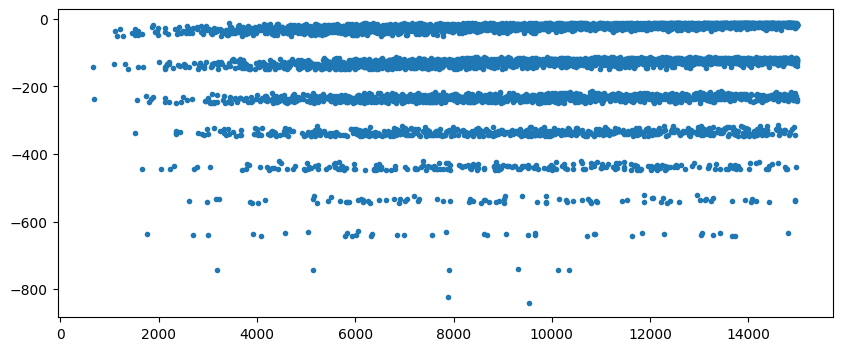

In [19]:
plot_frequence_sol(solutions)

Plus on relance les tests, plus la chance de trouver une solution peu coûteuse apparaît...


In [20]:
import matplotlib.pyplot as plt

In [21]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

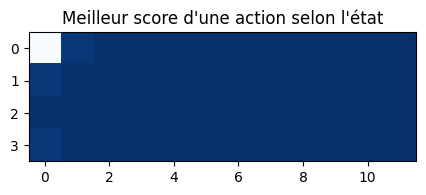

In [22]:
showBestValues(QA)

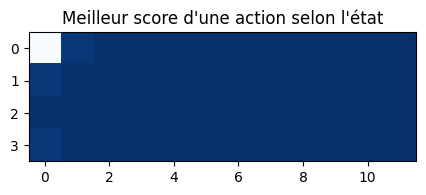

In [23]:
showBestValues(QB)

In [24]:
import seaborn as sns

In [25]:
# Author: Andrea Pierré
# License: MIT License
def qtable_directions_map(qtable):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(4, 12)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(4, 12)
    directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = 0#np.finfo(float).min #np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] < eps:
            # Assign an arrow only if a Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(4, 12)
    return qtable_val_max, qtable_directions

In [26]:
# Author: Andrea Pierré
# License: MIT License
def plot_q_values_map(qtable):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

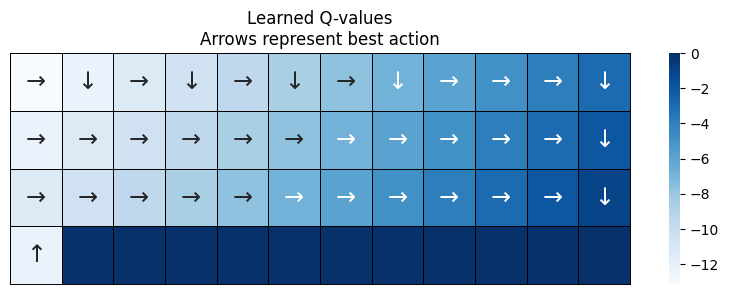

In [27]:
plot_q_values_map(QA )

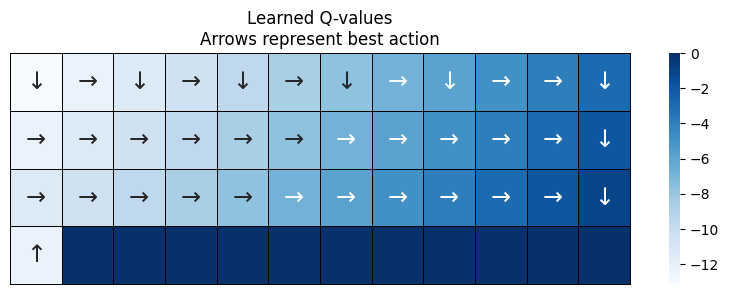

In [28]:
plot_q_values_map(QB )

## L'algorithme de Simple Q-Learning


In [29]:
import numpy as np
import random as rnd
from tqdm import tqdm

env = gym.make('CliffWalking-v0', render_mode='ansi')

In [30]:
Q = np.zeros([env.observation_space.n,env.action_space.n])


In [31]:
lambda_learn = .2
gamma = 0.8
epsilon = 1.

In [32]:
def q_learn_simple(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        Q[s, a] = (1-lambda_learn)*Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

In [33]:
def try_qlearn_simple(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list = q_learn_simple()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

In [34]:
def rendu_simple(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())

In [35]:
##ON LANCE LA RESOLUTION : 
solutions_simple = try_qlearn_simple(3000, 50)
if(len(solutions_simple)>0):rendu_simple(solutions_simple)
#relancer le bloc si pas de solution trouvee

100%|██████████| 3000/3000 [00:01<00:00, 1789.12it/s]

une solution en  13  etapes : 
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  

In [36]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")    
    plt.title("Fréquence d'apparition de solution")
    plt.show()

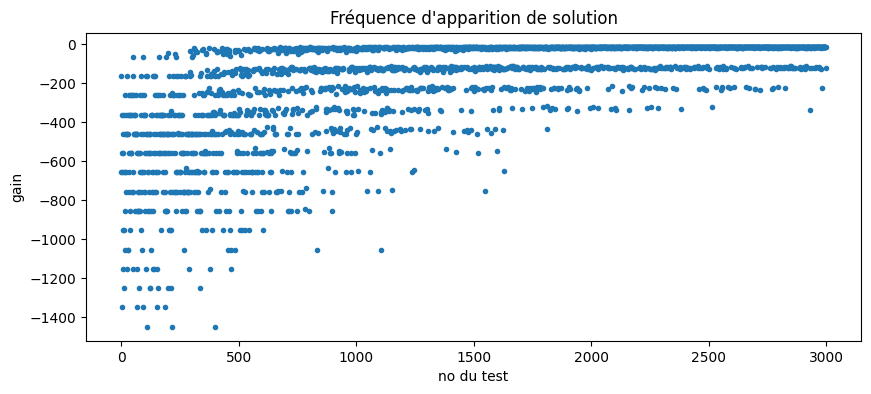

In [37]:
plot_frequence_sol(solutions_simple)

In [38]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

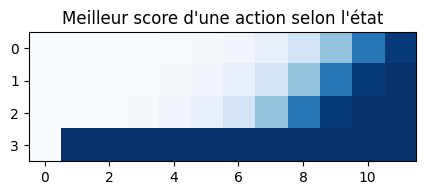

In [39]:
showBestValues(Q)

## L'algotithme Delayed Q-Learning


In [40]:
import numpy as np
import random as rnd
from tqdm import tqdm

env = gym.make('CliffWalking-v0', render_mode='ansi')


In [41]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

In [42]:
lambda_learn = .2
gamma = 0.8
epsilon = 1.

In [43]:
def q_learn_delayed(nb_actions=64, m=10):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    memory = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions = Q[s, :]
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)
        memory.append((s, a, r, new_state))

        # to privilegiate the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        if step%m == 0:
            for s, a, r, new_state in memory:
                Q[s, a] = Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
                total_r = total_r + r
            memory.clear()

        s = new_state
        
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

In [44]:
def try_qlearn_delayed(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list = q_learn_delayed()
        epsilon = epsilon * 0.999
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

In [45]:
def rendu_delayed(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())

In [46]:
##ON LANCE LA RESOLUTION : 
solutions_delayed = try_qlearn_delayed(3000, 50)
if(len(solutions_delayed)>0):rendu_delayed(solutions_delayed)
#relancer le bloc si pas de solution trouvee

100%|██████████| 3000/3000 [00:01<00:00, 1912.06it/s]

une solution en  13  etapes : 
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  

In [47]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("no du test")
    plt.ylabel("gain")    
    plt.title("Fréquence d'apparition de solution")
    plt.show()

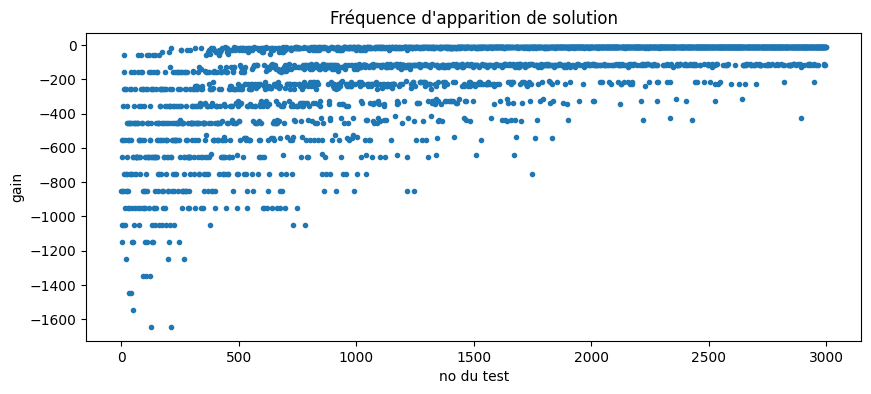

In [48]:
plot_frequence_sol(solutions_delayed)

In [54]:
def showBestValues(Q):
    #bestQValues contient les meilleures valeurs des actions possibles pour chaque état
    #et on "dilate" les valeurs pour augmenter leurs différences (utile pour le choix des couleurs)
    bestQ = [-(max(ligne))**50 for ligne in Q]
    #on transforme bestQValues en matrice 4 x 12
    bestQValues = np.reshape(bestQ, (4,12))
    #on demande à python de générer une "heatmap" 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Meilleur score d'une action selon l'état")
    plt.show()

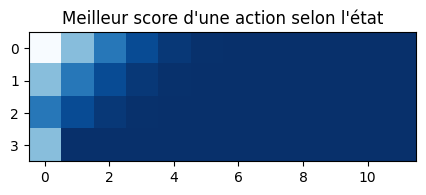

In [50]:
showBestValues(Q)

In [51]:
# Author: Andrea Pierré
# License: MIT License
def plot_q_values_map(qtable):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

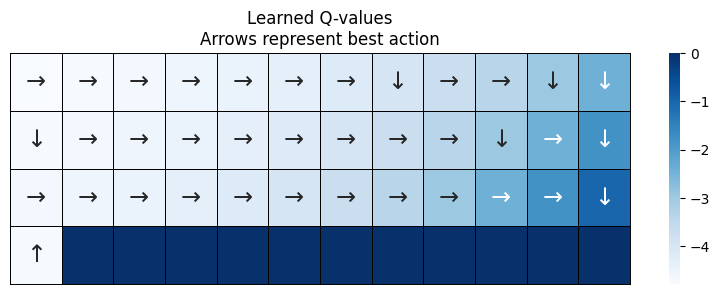

In [52]:
plot_q_values_map(Q)